# Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
sys.path.append(os.path.abspath("../.."))

In [42]:
import pandas
import optuna
from random import random, randint
import numpy
import torch
from typing import Callable
from tqdm import tqdm
from belashovplot import TiledPlot
from parameters import FigureWidthHeight, FontLibrary
from utilities import upper_integer
from math import sqrt
from itertools import product
import matplotlib.pyplot as plt

In [3]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (10, 10)

# Импорты и загрузка бызы исследований

In [4]:
study = optuna.create_study(study_name="ID2NN", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-03 22:29:06,836] Using an existing study with name 'ID2NN' instead of creating a new one.


In [5]:
trials = [trial for trial in study.trials if trial.values != None]
if len(trials) != len(study.trials):
    optuna.delete_study(study_name="ID2NN", storage="sqlite:///ID2NN.db")
    study = optuna.create_study(study_name="ID2NN", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)
    study.add_trials(trials)

[I 2024-05-03 22:29:07,517] A new study created in RDB with name: ID2NN


In [6]:
print(f"Кол-во исследований: {len(study.trials)}")
dataframe:pandas.DataFrame = study.trials_dataframe()

Кол-во исследований: 176


In [7]:
dataframe.nlargest(7, 'value')

,number,value,datetime_start,datetime_complete,duration,params_batch size,params_cross entorpy proportion,params_distance,params_learning rate,params_masks amount,params_optimizer type,state
108,108,30.02,2024-05-02 22:18:41.949319,2024-05-02 22:30:25.700272,0 days 00:11:43.750953,36,0.931286,0.080028,0.005589,6,RMSprop,COMPLETE
109,109,29.42,2024-05-02 22:30:25.719252,2024-05-02 22:42:09.999907,0 days 00:11:44.280655,36,0.992874,0.080766,0.005603,6,RMSprop,COMPLETE
98,98,28.49,2024-05-02 20:14:43.743453,2024-05-02 20:26:12.713107,0 days 00:11:28.969654,36,0.998300,0.081343,0.011329,6,RMSprop,COMPLETE
100,100,28.14,2024-05-02 20:37:39.429840,2024-05-02 20:49:05.629821,0 days 00:11:26.199981,36,0.989917,0.082269,0.005834,6,RMSprop,COMPLETE
142,142,28.02,2024-05-03 06:40:24.833215,2024-05-03 06:53:22.400377,0 days 00:12:57.567162,35,0.963454,0.082129,0.018239,7,RMSprop,COMPLETE
102,102,27.87,2024-05-02 21:00:42.075967,2024-05-02 21:13:53.128188,0 days 00:13:11.052221,36,0.998009,0.080214,0.010444,7,RMSprop,COMPLETE
103,103,27.74,2024-05-02 21:13:53.149167,2024-05-02 21:26:59.921876,0 days 00:13:06.772709,36,0.994113,0.080439,0.010096,7,RMSprop,COMPLETE


# Векторизация данных

In [8]:
target_key = 'value'
target_type = dataframe.dtypes['value']
parameters_keys = [key for key in dataframe.keys() if key.startswith('params_')]
parameters_types = [dataframe.dtypes[key] for key in parameters_keys]

def vectorize(values:list):
    unique = set(dataframe[pkey])
    object_map = dict(zip(unique, numpy.linspace(0, 1, len(unique))))
    array = [object_map[value] for value in dataframe[pkey].values]
    return array

vectors = torch.zeros((len(parameters_keys), len(dataframe)), dtype=torch.float32, requires_grad=False)
for i, (pkey, ptype) in enumerate(zip(parameters_keys, parameters_types)):
    if ptype == 'object': array = vectorize(dataframe[pkey].values)
    else:                 array = dataframe[pkey].values
    vectors[i] = torch.tensor(array)
vectors = vectors.swapdims(0,1)
vectors_maxs, _ = torch.max(vectors, dim=0, keepdim=True)
vectors_mins, _ = torch.min(vectors, dim=0, keepdim=True)
normalized_vectors = (vectors - vectors_mins) / (vectors_maxs - vectors_mins)
if target_type == 'object': array = vectorize(dataframe[target_key].values)
else:                       array = dataframe[target_key].values
targets = torch.tensor(array, dtype=torch.float32)
target_name = target_key
vector_names = [key[len('params_'):] for key in parameters_keys]

# Проекции

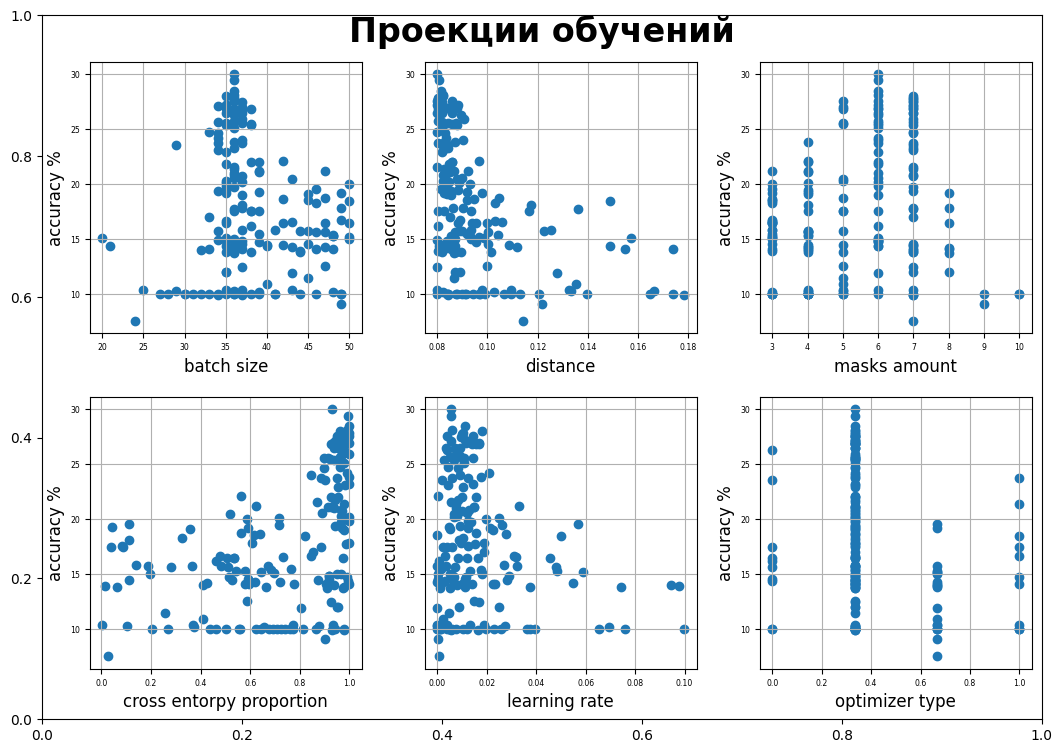

In [9]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title(f"Проекции обучений")
plot.pad.graph.horizontal(0.2)
plot.pad.graph.vertical(0.2)

cols = upper_integer(sqrt(vectors.shape[1]))
rows = upper_integer(vectors.shape[1]/cols)
colrow = product(range(cols), range(rows))

for (col, row), (x_num, x_name) in zip(colrow, enumerate(vector_names)):
    axes = plot.axes.add(col,row)
    axes.grid(True)
    axes.scatter(vectors[:,x_num].clone().detach(), targets.clone().detach())
    plot.graph.label.x(x_name)
    plot.graph.label.y('accuracy %')

plot.show()

# Функция оптимизация случайной проекции

In [10]:
def optimize_projection_2d(vectors:torch.Tensor, targets:torch.Tensor, minimization:Callable[[torch.Tensor,torch.Tensor],torch.Tensor]):
    vectors = vectors.requires_grad_(True)
    targets = targets.requires_grad_(True)
    rate = 1.0E-4
    with torch.enable_grad():
        parameters = torch.nn.Parameter(torch.normal(0., 0.1, (vectors.shape[1], 2)))
        # parameters = torch.nn.Parameter(torch.ones((vectors.shape[1], 2)))
        # print('parameters:', list(torch.abs(parameters).flatten().clone().detach().numpy()))

        loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
        loss.backward()
        prev_loss = loss.item()
        prev_grad = parameters.grad.clone().detach()

        # print('prev_grad:', list(prev_grad.flatten().clone().detach().numpy()))
        while rate > 1.0E-16 and prev_loss != 0:
            with torch.no_grad():
                random_values = torch.normal(0., 0.01, (vectors.shape[1], 2))
            loss = minimization(torch.matmul(vectors, torch.abs(random_values)), targets)
            with torch.no_grad():
                if loss.item() < prev_loss:
                    rate *= 1.5
                    parameters = parameters.copy_(random_values)
                    with torch.enable_grad():
                        loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
                    prev_loss = loss.item()
                    loss.backward()
                    prev_grad = parameters.grad.clone().detach()
                    parameters.grad.zero_()
                    continue
            
            with torch.no_grad():
                random_shift = torch.normal(0., 0.01, (vectors.shape[1], 2))
                parameters.copy_(parameters + random_shift)
            loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
            with torch.no_grad():
                if loss.item() >= prev_loss:
                    parameters.copy_(parameters - random_shift)
                else:
                    rate *= 1.5
                    prev_loss = loss.item()
                    loss.backward()
                    prev_grad = parameters.grad.clone().detach()
                    parameters.grad.zero_()
                    continue
            
            with torch.no_grad():
                parameters.copy_(parameters - rate*prev_grad)
            loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
            with torch.no_grad():
                if loss.item() >= prev_loss:
                    parameters.copy_(parameters + rate*prev_grad)
                    rate /= 2.0
                    continue
                else:
                    # print('parameters:', list(torch.abs(parameters).flatten().clone().detach().numpy()))
                    rate *= 1.3242135
                    prev_loss = loss.item()
                    loss.backward()
                    prev_grad = parameters.grad.clone().detach()
                    # print('prev_grad:', list(prev_grad.flatten().clone().detach().numpy()))
                    parameters.grad.zero_()
    return torch.matmul(vectors, torch.abs(parameters)).clone().detach(), torch.abs(parameters).clone().detach()

# Равномерное распределение

In [11]:
def uniform_(projection:torch.Tensor, targets:torch.Tensor):
    x_mesh, y_mesh = projection[:,0].view(1,-1), projection[:,1].view(1,-1)
    dR2 = (x_mesh - x_mesh.T)**2 + (y_mesh - y_mesh.T)**2
    mask = dR2 != 0
    dR2 = torch.where(mask, dR2, 1.0E-8)
    dR = torch.sqrt(dR2)
    phis = torch.mean(torch.where(mask, 1/dR, 0), dim=1)
    mean_phi = torch.mean(phis)
    result = torch.mean((phis - mean_phi)**2)
    return result

_uniform_n = 40
def uniform(projection:torch.Tensor, targets:torch.Tensor):
    x_array = torch.linspace(projection[:,0].min(), projection[:,0].max(), _uniform_n)
    y_array = torch.linspace(projection[:,1].min(), projection[:,1].max(), _uniform_n)
    coordinates = torch.stack(torch.meshgrid(x_array, y_array, indexing='ij')).reshape(2, -1).swapdims(0,1)
    dX = coordinates[:,0].view(1,-1) - projection[:,0].view(1,-1).T
    dY = coordinates[:,1].view(1,-1) - projection[:,1].view(1,-1).T
    
    dR2 = dX**2 + dY**2
    mask = dR2 != 0
    dR2 = torch.where(mask, dR2, 1.0E-8)
    dR = torch.sqrt(dR2)
    phis = torch.mean(1.0 / (1.0 + dR), dim=0)
    # phis = torch.mean(torch.where(mask, 1/dR, 0), dim=0)
    mean_phi = torch.mean(phis)

    # deltas = torch.abs(phis - mean_phi)*2
    deltas = torch.log10(torch.abs(phis - mean_phi) + 1.0)
    result = torch.max(deltas)
    return result

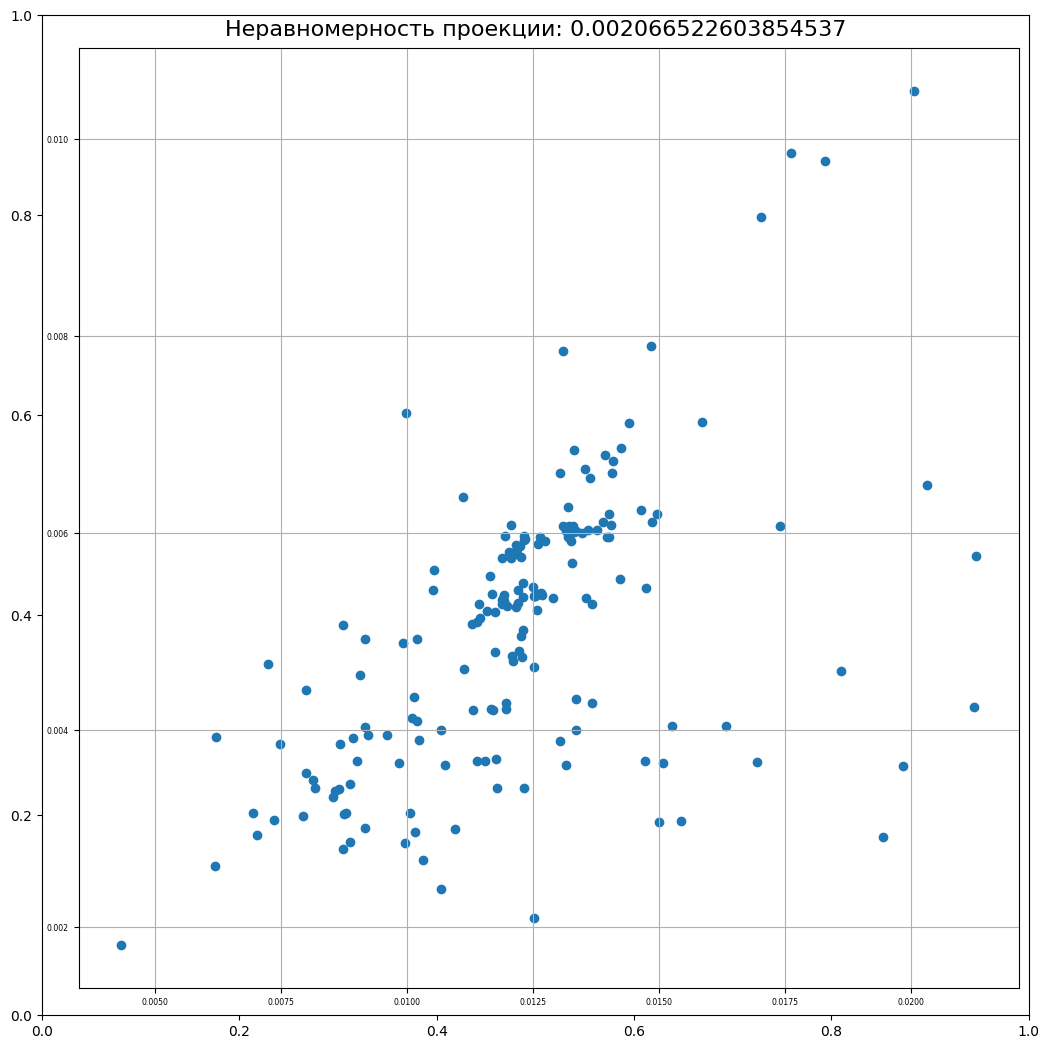

In [12]:
projection, matrix = optimize_projection_2d(normalized_vectors, targets, uniform)
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.description.top(f"Неравномерность проекции: {uniform(projection, targets)}")
axes = plot.axes.add(0,0)
axes.grid(True)
axes.scatter(projection[:,0], projection[:,1])
plot.show()

# Энкодер

In [13]:
def train(model:torch.nn.Module, optimizer:torch.optim.Optimizer, minimization:Callable[[torch.Tensor],torch.Tensor], vectors:torch.Tensor, iterations:int=1000):
    with torch.enable_grad():
        model.train()
        iterator = tqdm(range(iterations))
        for i in iterator:
            optimizer.zero_grad()
            result = model.forward(vectors)
            loss = minimization(result)
            loss.backward()
            optimizer.step()
            iterator.set_description(f"Loss ({i+1}): {loss.item()}")
        encoder.eval()

# Тренировка интерполятора

In [83]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(vectors.shape[1], 256*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(256*vectors.shape[1]),
    torch.nn.Linear(256*vectors.shape[1], 256*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(256*vectors.shape[1]),
    torch.nn.Linear(256*vectors.shape[1], 256*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(256*vectors.shape[1]),
    torch.nn.Linear(256*vectors.shape[1], 2),
)
interpolator = torch.nn.Sequential(
    torch.nn.Linear(2, 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 128*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(128*vectors.shape[1], 1),
    torch.nn.Sigmoid(),
)
encode_interpolate = torch.nn.Sequential(encoder, interpolator)
def interpolator_loss(accuracy:torch.Tensor):
    return torch.mean((100*accuracy.squeeze() - targets)**2)
optimizer = torch.optim.Adam(interpolator.parameters(), lr=1.0E-4)
train(encode_interpolate, optimizer, interpolator_loss, normalized_vectors, 1000)

Loss (1000): 1.7906279563903809: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:25<00:00,  4.86it/s]


### Тренировка декодера

In [84]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(512*vectors.shape[1], vectors.shape[1]),
    torch.nn.Sigmoid(),
)
def decoder_loss(vectors_:torch.Tensor):
    return torch.nn.functional.mse_loss(normalized_vectors, vectors_)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1.0E-5)
train(decoder, optimizer, decoder_loss, encoder.forward(normalized_vectors).clone().detach(), 500)

Loss (500): 0.09665428847074509: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


## Визуализация

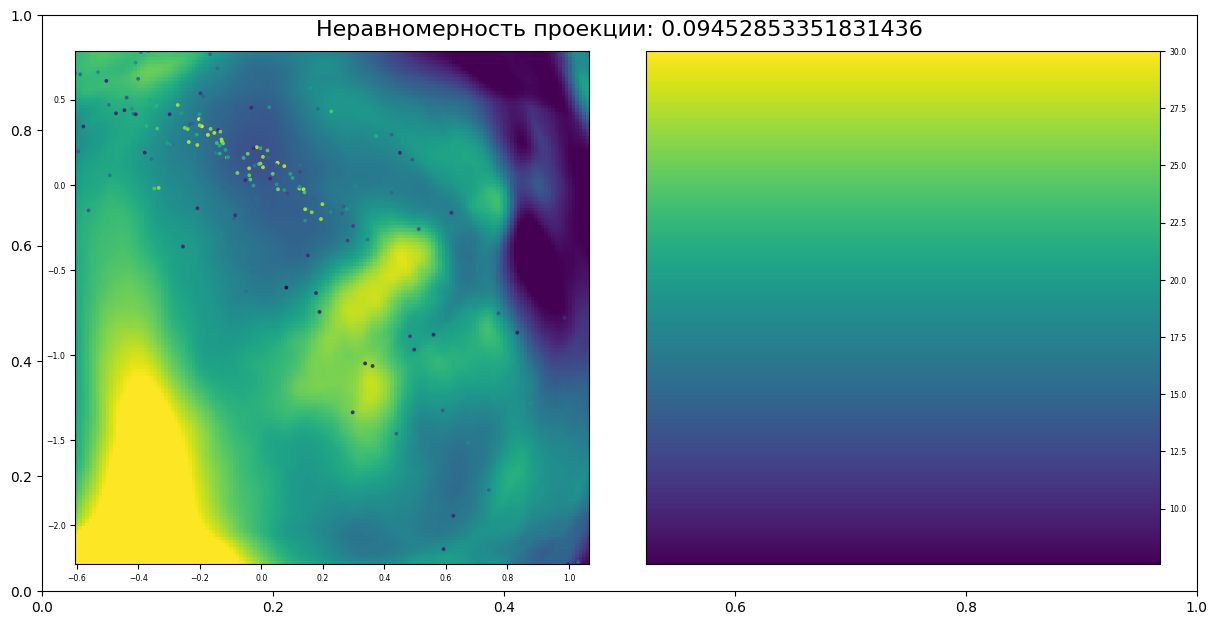

In [85]:
with torch.no_grad():
    projection = encoder.forward(normalized_vectors)
    plot = TiledPlot(*FigureWidthHeight)
    plot.FontLibrary = FontLibrary
    plot.description.top(f"Неравномерность проекции: {uniform(projection, targets)}")
    axes = plot.axes.add(0,0)
    scatter = axes.scatter(projection[:,0], projection[:,1], c=targets, s=3)

    N = 150
    x_array = torch.linspace(projection[:,0].min(), projection[:,0].max(), N)
    y_array = torch.linspace(projection[:,1].min(), projection[:,1].max(), N)
    coordinates = torch.stack(torch.meshgrid(x_array, y_array, indexing='ij')).reshape(2, -1).swapdims(0,1)
    accuracy = 100*interpolator.forward(coordinates)
    image = axes.imshow(accuracy.reshape(N, N), aspect='auto', extent=[x_array[0], x_array[-1], y_array[0], y_array[-1]], vmin=targets.min(), vmax=targets.max())

    axes = plot.axes.add(1, 0)
    plt.colorbar(image, cax=axes)
    # plt.colorbar(scatter, cax=axes)
    
    plot.show()